## Can You Predict Product Backorders?


### Project:
Ultimately, backordering boils down to having orders that you can’t fulfill or more orders than you have stock on hand. It’s a dream for any business but it’s also a huge problem if you don’t know how to handle it.
In this project we are trying to identify parts at risk of backorder before the event occurs so the business has time to react.

### Data:
Data is Based on historical data predict backorder risk for products
Training data file contains the historical data for the 8 weeks prior to the week we are trying to predict. 
The data was taken as weekly snapshots at the start of each week.
data is from kaggle :
https://www.kaggle.com/tiredgeek/predict-bo-trial/data

##### Data Wrangling and Cleaning:
The data come in the form of MS Excel spreadsheets, which are easily loaded into pandas dataframes.
in this data sets we have Yes/No fields which are converted in to binary integers.
-99 values in performance columns which are missing values and replaced by median.
we have some NaNs in lead_time but we are not sure that are missing or not.
It's quite likely that when lead_time is missing, it's missing for a reason and not at random, which means a mean/median imputation strategy may not be appropriate.
I prefer to decide by looking at data with calculationg the proportion of backordered products with vs. without a missing value in lead_time.
Since the data set is very big I decided to reduce data by capturing 60% of the total sales volume which is a big reduction in data for not much loss of fidelity.

##### Data Visualization
For data visualization I use transformation(square root) thats appropriate for heavy tailed data.

In [452]:
import decimal

import pandas as pd
import numpy as np

from scipy import stats

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import normalize
from sklearn import preprocessing

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn import tree, ensemble
from sklearn.linear_model import Ridge

from sklearn.metrics import roc_curve, auc


In [453]:
#train_data_=train_data


In [454]:
backorder_file = pd.read_csv("Kaggle_Training_Dataset_v2.csv")

orders = (backorder_file
              .drop(backorder_file.index[len(backorder_file)-1])# drop invalid last row
              .replace(['Yes', 'No'], [1, 0]))               # make yes/no numeric

C:\Users\Hedi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [455]:
orders.tail()
#data Information
orders.info()
#data description
orders.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1687860 entries, 0 to 1687859
Data columns (total 23 columns):
sku                  1687860 non-null object
national_inv         1687860 non-null float64
lead_time            1586967 non-null float64
in_transit_qty       1687860 non-null float64
forecast_3_month     1687860 non-null float64
forecast_6_month     1687860 non-null float64
forecast_9_month     1687860 non-null float64
sales_1_month        1687860 non-null float64
sales_3_month        1687860 non-null float64
sales_6_month        1687860 non-null float64
sales_9_month        1687860 non-null float64
min_bank             1687860 non-null float64
potential_issue      1687860 non-null int64
pieces_past_due      1687860 non-null float64
perf_6_month_avg     1687860 non-null float64
perf_12_month_avg    1687860 non-null float64
local_bo_qty         1687860 non-null float64
deck_risk            1687860 non-null int64
oe_constraint        1687860 non-null int64
ppap_risk           

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
count,1.687860e+06,1.586967e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,...,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06
mean,4.961118e+02,7.872267e+00,4.405202e+01,1.781193e+02,3.449867e+02,5.063644e+02,5.592607e+01,1.750259e+02,3.417288e+02,5.252697e+02,...,2.043724e+00,-6.872059e+00,-6.437947e+00,6.264507e-01,2.295706e-01,1.451542e-04,1.207648e-01,9.638086e-01,4.330928e-04,6.690721e-03
std,2.961523e+04,7.056024e+00,1.342742e+03,5.026553e+03,9.795152e+03,1.437892e+04,1.928196e+03,5.192378e+03,9.613167e+03,1.483861e+04,...,2.360165e+02,2.655636e+01,2.584333e+01,3.372224e+01,4.205568e-01,1.204713e-02,3.258538e-01,1.867661e-01,2.080638e-02,8.152275e-02
min,-2.725600e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-9.900000e+01,-9.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,6.300000e-01,6.600000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
50%,1.500000e+01,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,...,0.000000e+00,8.200000e-01,8.100000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.000000e+01,9.000000e+00,0.000000e+00,4.000000e+00,1.200000e+01,2.000000e+01,4.000000e+00,1.500000e+01,3.100000e+01,4.700000e+01,...,0.000000e+00,9.700000e-01,9.500000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,1.233440e+07,5.200000e+01,4.894080e+05,1.427612e+06,2.461360e+06,3.777304e+06,7.417740e+05,1.105478e+06,2.146625e+06,3.205172e+06,...,1.464960e+05,1.000000e+00,1.000000e+00,1.253000e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


### Data Preparation

In [456]:
#missing values in product
orders.sku.isnull().sum()

0

In [457]:
#missing value 
orders.isnull().sum()

sku                       0
national_inv              0
lead_time            100893
in_transit_qty            0
forecast_3_month          0
forecast_6_month          0
forecast_9_month          0
sales_1_month             0
sales_3_month             0
sales_6_month             0
sales_9_month             0
min_bank                  0
potential_issue           0
pieces_past_due           0
perf_6_month_avg          0
perf_12_month_avg         0
local_bo_qty              0
deck_risk                 0
oe_constraint             0
ppap_risk                 0
stop_auto_buy             0
rev_stop                  0
went_on_backorder         0
dtype: int64

In [458]:
#replacing -99 missing values to mean
for col in ['perf_6_month_avg', 'perf_12_month_avg']:
    orders[col] = Imputer(missing_values=-99).fit_transform(
                                    orders[col].values.reshape(-1, 1))

### EDA

###### Went on bsckorder

In [459]:
#backorder ratio
prob=len(orders[orders.went_on_backorder==1])/len(orders.sku)
print((prob*100),'%')
print(len(orders[orders.went_on_backorder==1]))


0.6690720794378681 %
11293


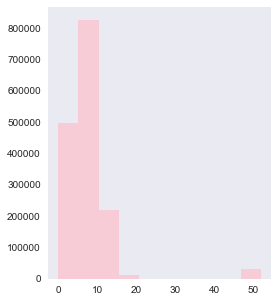

In [460]:
orders['lead_time'].hist(figsize=(4,5), alpha=0.7, color='pink', grid=False)
plt.show()

###### Lead Time and Went on backorder

check the missing data in lead time to replace it or not?
1. Proportion of orders that “went_on_backorder” for missing lead_time records
2. Proportion of orders that “went_on_backorder” for non-null lead_time records

In [461]:
n_null_leadTime = orders[orders['lead_time'].isnull()].shape[0]
print ('number of orders with missing lead time:', orders[orders['lead_time'].isnull()].shape[0])
n_non_null_leadTime = orders[orders['lead_time'].notnull()].shape[0]
print ('number of orders without missing lead time:',orders[orders['lead_time'].notnull()].shape[0])
n_null_leadTime_backorders =sum(orders[np.isnan(orders["lead_time"])]["went_on_backorder"])
print ('Number of backordered products with misssing lead time:', n_null_leadTime_backorders)
n_non_null_leadTime_backorders = sum(orders[pd.notnull(orders["lead_time"])]["went_on_backorder"])
print  ('Number of backordered products without misssing lead time:',n_non_null_leadTime_backorders)
print ('Total orders went on backorders:',n_null_leadTime_backorders+ n_non_null_leadTime_backorders)
null_leadTime_backorder_ratio = n_null_leadTime_backorders / float(n_null_leadTime)
non_null_leadTime_backorder_ratio = n_non_null_leadTime_backorders / float(n_non_null_leadTime)
print('Proportion of orders without missing lead time that went_on_backorder:',non_null_leadTime_backorder_ratio * 100)
print('Proportion of orders with missing lead_time that went_on_backorder :', null_leadTime_backorder_ratio * 100)


number of orders with missing lead time: 100893
number of orders without missing lead time: 1586967
Number of backordered products with misssing lead time: 324
Number of backordered products without misssing lead time: 10969
Total orders went on backorders: 11293
Proportion of orders without missing lead time that went_on_backorder: 0.691192696508
Proportion of orders with missing lead_time that went_on_backorder : 0.321132288662


Based on the above calculations the proportion of backordered products with missing lead time is 50% less than those without missing lead time.
The proportion of backordere products with missing lead time is half of the products with no missing values, therefore I decided not to replace the missing data in lead time and droping them.
Plot below shows the density of products for a given lead time that went on backorder and did not go on backorder.

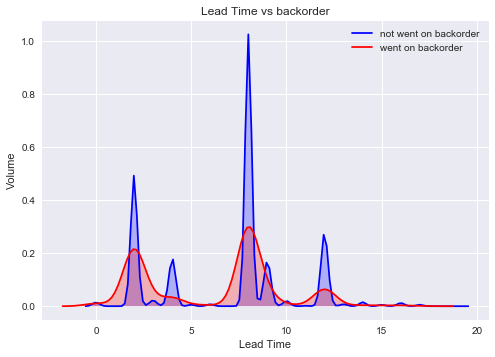

In [462]:
#Relationship between lead time and went on backorder
sns.kdeplot(orders[(orders['went_on_backorder'] == 0) & (orders['lead_time'] < 20)]['lead_time'],color='b', shade=True,label='not went on backorder',)
sns.kdeplot(orders[(orders['went_on_backorder'] == 1) & (orders['lead_time'] < 20)]['lead_time'], color='r',shade=True,label='went on backorder')
plt.title('Lead Time vs backorder')
plt.ylabel('Volume')
plt.xlabel('Lead Time')
plt.show()

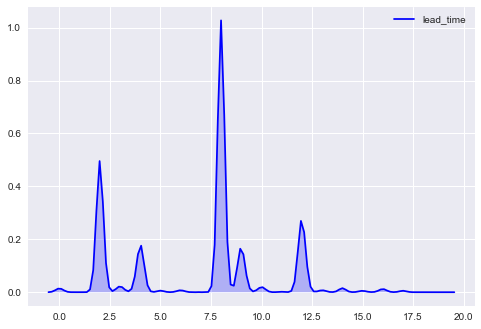

In [463]:
sns.kdeplot(orders[(orders['lead_time'] < 20)]['lead_time'],color='b',shade="True")
plt.show()

Here we can see that both backorder and not backorder products have the same peak Lead time, because the orders on that particular lead time are high. However, the backorder plot is lower than not backorder plot.
You can see that plot of lead time is exactly look like the plot of lead time with not backorder data it means that most of the products are not going on backorder and if we choose the random sample of data it will be the same distribution.
Therefore we are going to see if lead time and went on backorder are independent or dependent from each other.
Next step is looking at the relationship between lead time and a fraction of products that went on backorder.
Let's look at the lead time and how it changes the probability of went to backorder.

##### Highest Transit time for product
Products that went on bacorder with lead time 8 weeks and then 2 weeks have the highest order volumes.

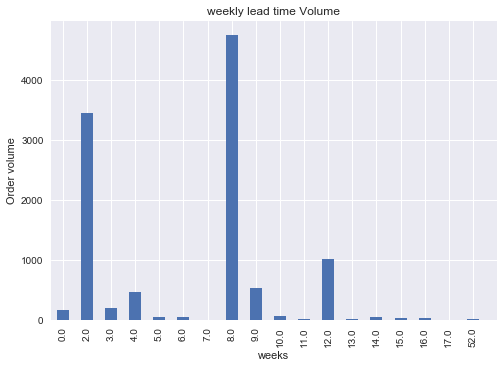

In [464]:
backorder_df=orders[orders['went_on_backorder']==1]
weekdist=backorder_df['lead_time'].value_counts().sort_index()
weekdist.plot(kind='bar')
_=plt.xlabel('weeks')
_=plt.ylabel('Order volume')
_=plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])
plt.title('weekly lead time Volume')
plt.show()


In [465]:
## These are the peak weeks
weekdist[weekdist>1000].sort_values(ascending=False)

8.0     4744
2.0     3457
12.0    1024
Name: lead_time, dtype: int64

Plot below shows the relation between lead time and the fraction of backorder. 
The following plot shows with longer lead time, backorder proportion goes down.

[[ 1.        -0.5420028]
 [-0.5420028  1.       ]]


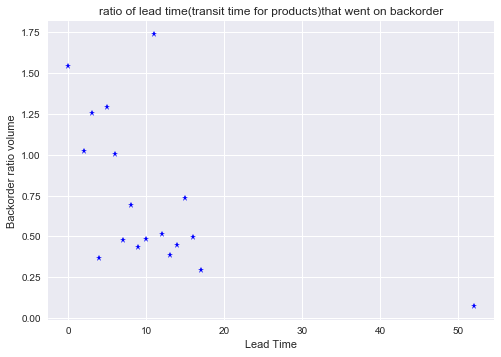

[1.5412425078489203, 1.0245938079797985, 1.2551528948501816, 0.36954339995487684, 1.2900024807740016, 1.006523765144455, 0.4784688995215311, 0.6954115153345275, 0.43348510703685433, 0.48618940248027059, 1.7367458866544789, 0.51276915373059584, 0.38852913968547642, 0.44599573395384917, 0.73452256033578167, 0.49756869840551843, 0.29231995748073347, 0.073058147643874735]


,lead_b,lead_n
0.0,162.0,10349
2.0,3457.0,333945
3.0,204.0,16049
4.0,475.0,128062
5.0,52.0,3979
6.0,54.0,5311
7.0,1.0,208
8.0,4744.0,677442
9.0,536.0,123113
10.0,69.0,14123


In [466]:
b=orders[['went_on_backorder','lead_time']]
backorder=b[b.went_on_backorder==1]
no_backorder=b[b.went_on_backorder==0]
lead_b=backorder.lead_time.value_counts()
lead_n=no_backorder.lead_time.value_counts()
c=[]
df1 = pd.DataFrame(
    {
     'lead_b': lead_b,
     'lead_n':lead_n
    })

df1=df1[['lead_b','lead_n']].dropna()


for i in range(0,len(df1)):
    backorder_ratio=(df1.lead_b.iloc[i])/(df1.lead_n.iloc[i]+df1.lead_b.iloc[i])
    backorder_ratio=backorder_ratio*100
    c.append(backorder_ratio)


print(np.corrcoef(df1.index.values,c))

plt.plot(df1.index.values,c,"*",color="blue")
plt.title('ratio of lead time(transit time for products)that went on backorder')
_=plt.xlabel('Lead Time')
_=plt.ylabel('Backorder ratio volume')
#plt.plot(np.array(range(len(c))) * 0.25, c,".")
plt.show()
print(c)
df1


In the above plot, two outlier are noticed. one is at lead time=11 and one at lead time 52. 
for the point on 52 I belive there was not enough records to show the rest of point between17 to 52.
the point at lead time 11 should be given special attention till its cause is known.
fo this reason I am going to calulate the probability bionomial distribution.

In [467]:
from scipy.stats import binom
import math
s = binom.pmf(19, 1094,0.01)
print(s)
sd=math.sqrt(1094 * 0.01 * (1 - 0.01))
print("Standard deviation ",sd)
print ((19 - 10.94)/sd)

0.00786682435841
Standard deviation  3.2909876936871094
2.449112774095443


As you see from the above calculations standard deviation of bionomial distribution is 3.23 standard deviation from the mean so I am going to ignore this point for now.

### Data Reduction:
Cumulative percentage is one way of expressing frequency distribution. 


C:\Users\Hedi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


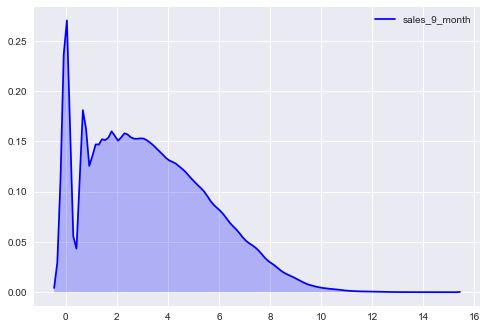

In [468]:
sales_sort=orders.sort_values('sales_9_month',ascending = False)
sns.kdeplot(np.log(sales_sort['sales_9_month']),color='b', shade=True)
plt.show()

###### Total sales and went on backorder

[[ 1.          0.90766073]
 [ 0.90766073  1.        ]]


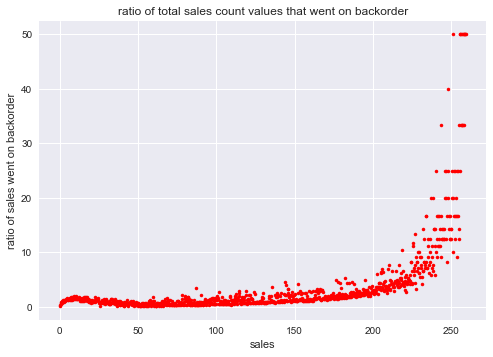

In [469]:
#relationship between sales and backorder
backorder_sales=sales_sort[sales_sort.went_on_backorder==1]
no_backorder_sales=sales_sort[sales_sort.went_on_backorder==0]
sales_b=backorder_sales.sales_9_month.value_counts()
sales_n=no_backorder_sales.sales_9_month.value_counts()
g=[]
df2 = pd.DataFrame(
    {
     'sales_b': sales_b,
     'sales_n':sales_n
    })

df2=df2[['sales_b','sales_n']].dropna()


for i in range(0,len(df2)):
    backorder_ratio=(df2.sales_b.iloc[i])/(df2.sales_n.iloc[i]+df2.sales_b.iloc[i])
    backorder_ratio=backorder_ratio*100
    g.append(backorder_ratio)


print(np.corrcoef(df2.index.values,g))
plt.plot(np.array(range(len(g))) * 0.25, g,".",color='red')
plt.title('ratio of total sales count values that went on backorder')
plt.xlabel('sales')
plt.ylabel('ratio of sales went on backorder')
plt.show()


883338607.0
530003164.2


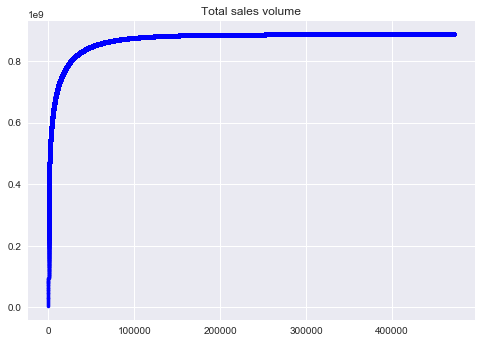

In [470]:
sales_volume =np.cumsum(sales_sort.sales_9_month)
print(sales_volume[len(sales_volume)-1])
print(0.6 * sales_volume[len(sales_volume)-1])
plt.plot(np.array(range(len(sales_sort))) * 0.28, sales_volume,".",color="blue")
plt.title('Total sales volume')
plt.show()

530003164.2
883338607.0


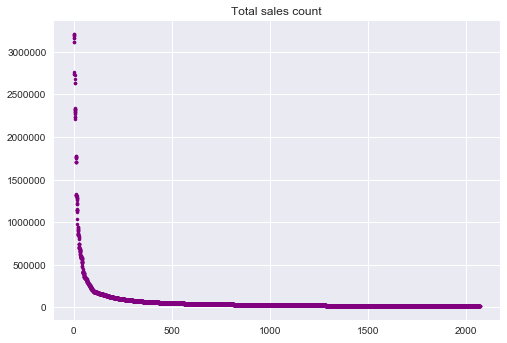

7397

In [471]:
volume_perc=0.6 * sales_volume[len(sales_volume)-1]
print(volume_perc)
print(sales_volume[len(sales_volume)-1])
sales_sort['sales_volume']=sales_volume

sales_sort=sales_sort.sort_values('sales_volume',ascending = True)
sample=sales_sort[sales_sort['sales_volume']<=volume_perc]

sample=sample.sort_values('sales_9_month',ascending = False)
plt.plot(np.array(range(len(sample))) * 0.28, sample.sales_9_month,".",color="purple")
plt.title('Total sales count')
plt.show()
len(sample)

So with capturing 60% total sales volume ,data is reduced to 7397 rows.

In [472]:
sample.lead_time.isnull().sum()

184

After Data reduction again look at the relationship between sales and went on backorder.
There is no relation between total sales and went on backorder now, the reason is high sales products they dont go on backorder

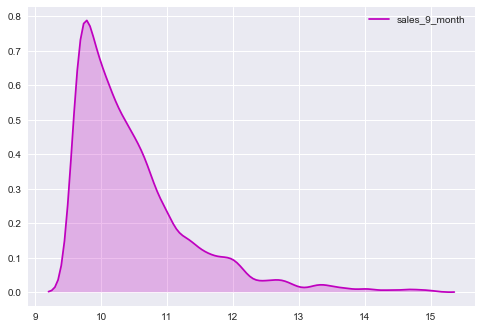

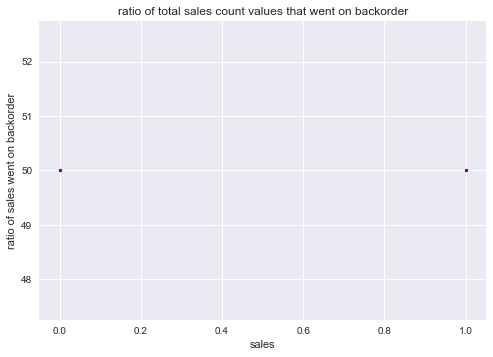

In [473]:
sales_sort_after=sample.sort_values('sales_9_month',ascending = False)
sns.kdeplot(np.log(sales_sort_after['sales_9_month']),color='m', shade=True)
plt.show()
backorder_sales_after=sales_sort_after[sales_sort_after.went_on_backorder==1]
no_backorder_sales_after=sales_sort_after[sales_sort_after.went_on_backorder==0]
sales_b=backorder_sales_after.sales_9_month.value_counts()
sales_n=no_backorder_sales_after.sales_9_month.value_counts()
g=[]
df2 = pd.DataFrame(
    {
     'sales_b': sales_b,
     'sales_n':sales_n
    })

df2=df2[['sales_b','sales_n']].dropna()


for i in range(0,len(df2)):
    backorder_ratio=(df2.sales_b.iloc[i])/(df2.sales_n.iloc[i]+df2.sales_b.iloc[i])
    backorder_ratio=backorder_ratio*100
    g.append(backorder_ratio)

plt.plot(np.array(range(len(g))), g,".",color='purple')
plt.title('ratio of total sales count values that went on backorder')
plt.xlabel('sales')
plt.ylabel('ratio of sales went on backorder')
plt.show()


********************************************

###### Dropping the missing values in lead time

In [474]:
Ordernomiss=orders.dropna()
Ordernomiss.isnull().sum().sum()

0

backorder ratio is higher when we drop the Nan values in lead time thats because most of the backorderes values were non backorders


In [475]:
prob=len(Ordernomiss[Ordernomiss.went_on_backorder==1])/len(Ordernomiss.sku)
print((prob*100),'%')
print(len(Ordernomiss[Ordernomiss.went_on_backorder==1]))

0.691192696508497 %
10969


C:\Users\Hedi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


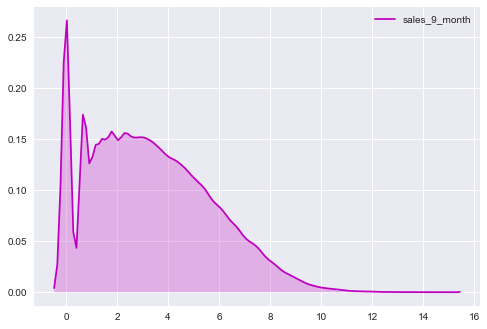

In [476]:
sales_nomiss=Ordernomiss.sort_values('sales_9_month',ascending = False)
sns.kdeplot(np.log(sales_nomiss['sales_9_month']),color='m', shade=True)
plt.show()

[[ 1.          0.90796433]
 [ 0.90796433  1.        ]]


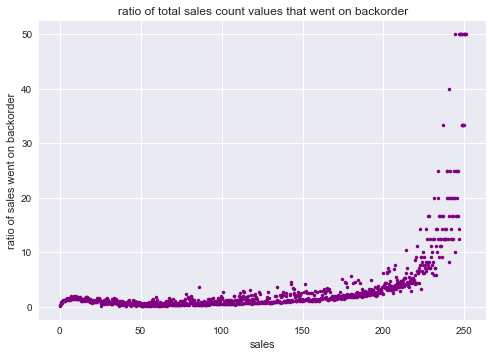

In [477]:
#relationship between sales and backorder
backorder_sales=sales_nomiss[sales_nomiss.went_on_backorder==1]
no_backorder_sales=sales_nomiss[sales_nomiss.went_on_backorder==0]
sales_b=backorder_sales.sales_9_month.value_counts()
sales_n=no_backorder_sales.sales_9_month.value_counts()
g=[]
df2 = pd.DataFrame(
    {
     'sales_b': sales_b,
     'sales_n':sales_n
    })

df2=df2[['sales_b','sales_n']].dropna()


for i in range(0,len(df2)):
    backorder_ratio=(df2.sales_b.iloc[i])/(df2.sales_n.iloc[i]+df2.sales_b.iloc[i])
    backorder_ratio=backorder_ratio*100
    g.append(backorder_ratio)


print(np.corrcoef(df2.index.values,g))
plt.plot(np.array(range(len(g))) * 0.25, g,".",color='purple')
plt.title('ratio of total sales count values that went on backorder')
plt.xlabel('sales')
plt.ylabel('ratio of sales went on backorder')
plt.show()


863511872.0
518107123.2


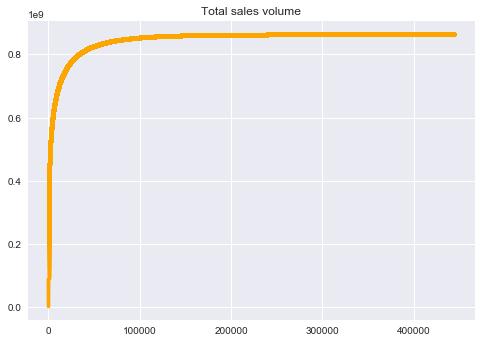

In [478]:
sales_volume_nomiss =np.cumsum(sales_nomiss.sales_9_month)
print(sales_volume_nomiss[len(sales_volume_nomiss)-1])
print(0.6 * sales_volume_nomiss[len(sales_volume_nomiss)-1])
plt.plot(np.array(range(len(sales_nomiss))) * 0.28, sales_volume_nomiss,".",color="orange")
plt.title('Total sales volume')
plt.show()


518107123.2
863511872.0


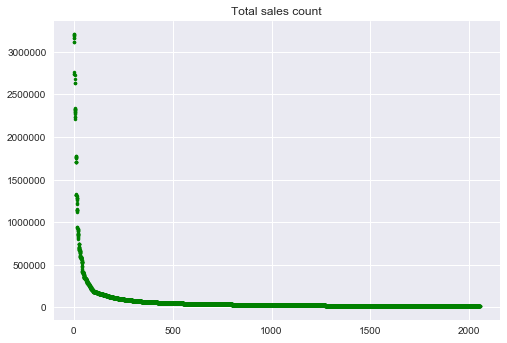

In [479]:
volume_perc=0.6 * sales_volume_nomiss[len(sales_volume_nomiss)-1]
print(volume_perc)
print(sales_volume_nomiss[len(sales_volume_nomiss)-1])
sales_nomiss['sales_volume_nomiss']=sales_volume_nomiss

sales_nomiss=sales_nomiss.sort_values('sales_volume_nomiss',ascending = True)
sample_nomiss=sales_nomiss[sales_nomiss['sales_volume_nomiss']<=volume_perc]

sample_nomiss=sample_nomiss.sort_values('sales_9_month',ascending = False)
plt.plot(np.array(range(len(sample_nomiss))) * 0.28, sample_nomiss.sales_9_month,".",color="green")
plt.title('Total sales count')
plt.show()
len(sample_nomiss)
sample_nomiss=sample_nomiss.drop('sales_volume_nomiss',axis=1)

there is not major differences when I dropped missing values of lead time so i think missing values in lead time doesnt effect our result.
next I want to replace it with median

In [480]:
orderimp=orders
orderimp['lead_time'] = Imputer(strategy='median').fit_transform(
                                    orderimp['lead_time'].values.reshape(-1, 1))    #replace missing lead time to median value

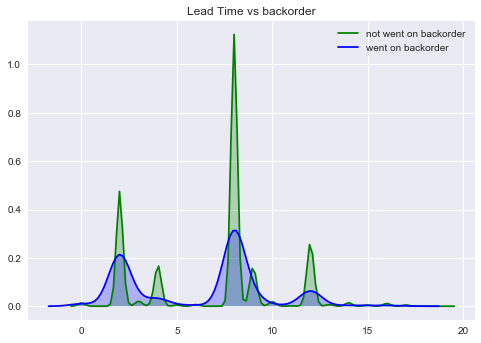

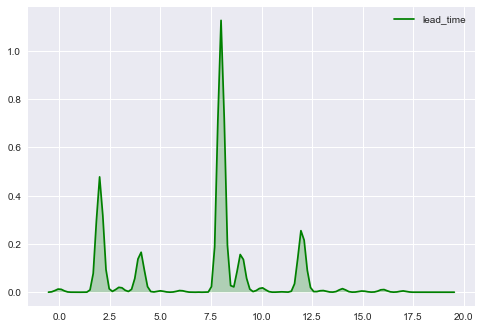

In [481]:
#Relationship between lead time and went on backorder
sns.kdeplot(orderimp[(orderimp['went_on_backorder'] == 0) & (orderimp['lead_time'] < 20)]['lead_time'],color='g', shade=True,label='not went on backorder')
sns.kdeplot(orderimp[(orderimp['went_on_backorder'] == 1) & (orderimp['lead_time'] < 20)]['lead_time'], color='b',shade=True,label='went on backorder')
plt.title('Lead Time vs backorder')
plt.show()
sns.kdeplot(orderimp[(orderimp['lead_time'] < 20)]['lead_time'],color='g',shade="True")
plt.show()

[[ 1.         -0.53975552]
 [-0.53975552  1.        ]]


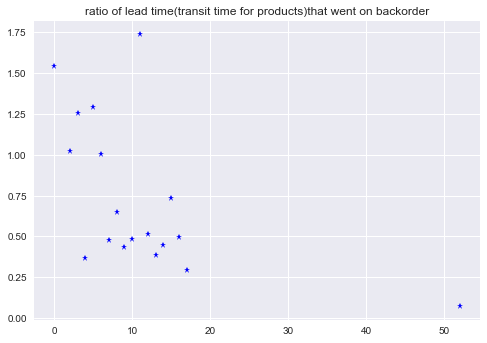

[1.5412425078489203, 1.0245938079797985, 1.2551528948501816, 0.36954339995487684, 1.2900024807740016, 1.006523765144455, 0.4784688995215311, 0.64718885323192166, 0.43348510703685433, 0.48618940248027059, 1.7367458866544789, 0.51276915373059584, 0.38852913968547642, 0.44599573395384917, 0.73452256033578167, 0.49756869840551843, 0.29231995748073347, 0.073058147643874735]


,lead_b,lead_n
0.0,162.0,10349
2.0,3457.0,333945
3.0,204.0,16049
4.0,475.0,128062
5.0,52.0,3979
6.0,54.0,5311
7.0,1.0,208
8.0,5068.0,778011
9.0,536.0,123113
10.0,69.0,14123


In [482]:
b=orderimp[['went_on_backorder','lead_time']]
backorder=b[b.went_on_backorder==1]
no_backorder=b[b.went_on_backorder==0]
lead_b=backorder.lead_time.value_counts()
lead_n=no_backorder.lead_time.value_counts()
c=[]
df1 = pd.DataFrame(
    {
     'lead_b': lead_b,
     'lead_n':lead_n
    })

df1=df1[['lead_b','lead_n']].dropna()


for i in range(0,len(df1)):
    backorder_ratio=(df1.lead_b.iloc[i])/(df1.lead_n.iloc[i]+df1.lead_b.iloc[i])
    backorder_ratio=backorder_ratio*100
    c.append(backorder_ratio)


print(np.corrcoef(df1.index.values,c))

plt.plot(df1.index.values,c,"*",color="blue")
plt.title('ratio of lead time(transit time for products)that went on backorder')
#plt.plot(np.array(range(len(c))) * 0.25, c,".")
plt.show()
print(c)
df1


883338607.0
530003164.2


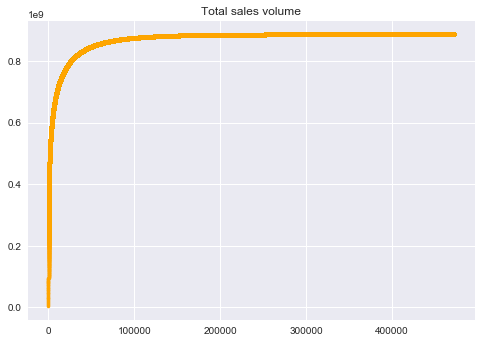

In [483]:
sales_imp=orderimp.sort_values('sales_9_month',ascending = False)
sales_volume_imp =np.cumsum(sales_imp.sales_9_month)
print(sales_volume_imp[len(sales_volume_imp)-1])
print(0.6 * sales_volume_imp[len(sales_volume_imp)-1])
plt.plot(np.array(range(len(sales_imp))) * 0.28, sales_volume_imp,".",color="orange")
plt.title('Total sales volume')
plt.show()

530003164.2
883338607.0


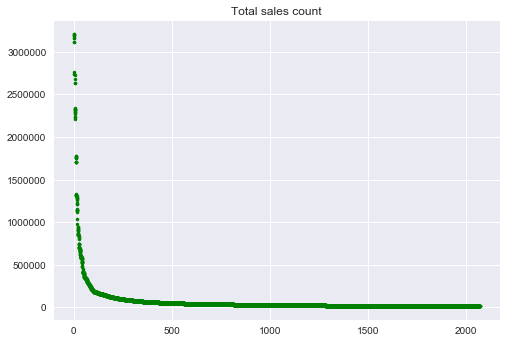

7397

In [484]:

volume_perc=0.6 * sales_volume_imp[len(sales_volume_imp)-1]
print(volume_perc)
print(sales_volume_imp[len(sales_volume_imp)-1])
sales_imp['sales_volume']=sales_volume

sales_imp=sales_imp.sort_values('sales_volume',ascending = True)
sample_imp=sales_imp[sales_imp['sales_volume']<=volume_perc]

sample_imp=sample_imp.sort_values('sales_9_month',ascending = False)
plt.plot(np.array(range(len(sample_imp))) * 0.28, sample_imp.sales_9_month,".",color="green")
plt.title('Total sales count')
plt.show()
len(sample_imp)

So based on above pbservations dropping Lead time is a good choice

###### How common are backorders?

How common are backorders? Given that, how likely are backorders based on the part risk flags? 
And how prevalent are they? 
What is the relationship between "potential_issue" and "pieces_past_due" are each represented by part 
risk flags or are they unrelated concepts? What's the relationship between lead time and back orders? 
Based on the answers to these questions you could recommend: What aspects of the supply chain present the biggest risks? 
Based on the risks, what would you recommend improving first?
    
potential_issue - Source issue for part identified

pieces_past_due - Parts overdue from source

local_bo_qty - Amount of stock orders overdue

deck_risk - Part risk flag

oe_constraint - Part risk flag

ppap_risk - Part risk flag

In [485]:
print(np.corrcoef(orders.potential_issue,orders.pieces_past_due))
print('Source issue for part identified correlation with backorder',np.corrcoef(orders.potential_issue,orders.went_on_backorder))
print('Parts overdue from source correlation with backorder', np.corrcoef(orders.went_on_backorder,orders.pieces_past_due))
print('Amount of stock orders overdue correlation with backorder',np.corrcoef(orders.went_on_backorder,orders.local_bo_qty))
print('oe_constraint - Part risk flag correlation with backorder',np.corrcoef(orders.went_on_backorder,orders.oe_constraint))
print('ppap_risk - Part risk flag correlation with backorder', np.corrcoef(orders.went_on_backorder,orders.ppap_risk))
print('Total sales for perior 9,6,3 and 1 month correlation with backorder',np.corrcoef(orders.went_on_backorder,orders.sales_9_month))
print('Total Forecast sales - Part risk flag correlation with backorder',np.corrcoef(orders.went_on_backorder,orders.forecast_9_month))


[[ 1.          0.00331913]
 [ 0.00331913  1.        ]]
Source issue for part identified correlation with backorder [[ 1.         0.0140902]
 [ 0.0140902  1.       ]]
Parts overdue from source correlation with backorder [[  1.00000000e+00   5.16086480e-04]
 [  5.16086480e-04   1.00000000e+00]]
Amount of stock orders overdue correlation with backorder [[ 1.          0.00950369]
 [ 0.00950369  1.        ]]
oe_constraint - Part risk flag correlation with backorder [[ 1.          0.00383717]
 [ 0.00383717  1.        ]]
ppap_risk - Part risk flag correlation with backorder [[ 1.         0.0088142]
 [ 0.0088142  1.       ]]
Total sales for perior 9,6,3 and 1 month correlation with backorder [[ 1.         -0.00176378]
 [-0.00176378  1.        ]]
Total Forecast sales - Part risk flag correlation with backorder [[ 1.         -0.00102983]
 [-0.00102983  1.        ]]


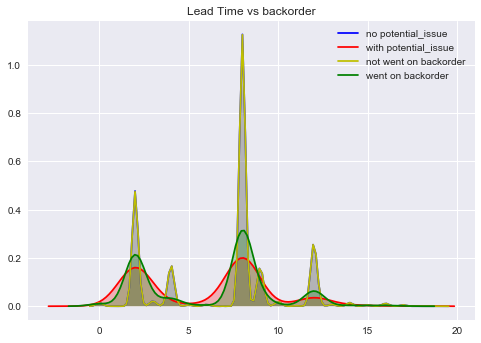

In [486]:
sns.kdeplot(orders[(orders['potential_issue'] == 0) & (orders['lead_time'] < 20)]['lead_time'],color='b', shade=True,label='no potential_issue')
sns.kdeplot(orders[(orders['potential_issue'] == 1) & (orders['lead_time'] < 20)]['lead_time'], color='r',shade=True,label='with potential_issue')
plt.title('Lead Time vs backorder and potential issue from the source')

sns.kdeplot(orders[(orders['went_on_backorder'] == 0) & (orders['lead_time'] < 20)]['lead_time'],color='y', shade=True,label='not went on backorder')
sns.kdeplot(orders[(orders['went_on_backorder'] == 1) & (orders['lead_time'] < 20)]['lead_time'], color='g',shade=True,label='went on backorder')
plt.title('Lead Time vs backorder')

plt.show()

above plot shows that went on backorder and potential issues have the same relation with lead time. mean when a products with certain lead time did not have the potential isse the products did not go on backorder.
so potentail issue is one of the main reason that a product went on backorder.

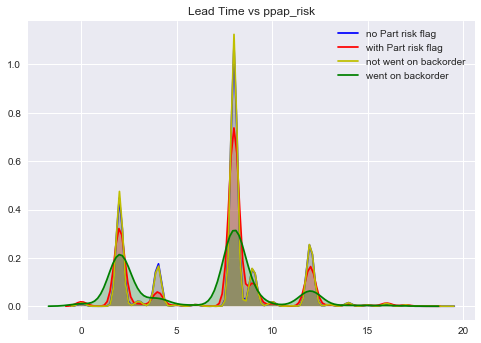

In [487]:
sns.kdeplot(orders[(orders['ppap_risk'] == 0) & (orders['lead_time']<20)]['lead_time'],color='b', shade=True,label='no Part risk flag')
sns.kdeplot(orders[(orders['ppap_risk'] == 1) & (orders['lead_time']<20)]['lead_time'], color='r',shade=True,label='with Part risk flag')
plt.title('lead time vs ppap_risk')

sns.kdeplot(orders[(orders['went_on_backorder'] == 0) & (orders['lead_time'] < 20)]['lead_time'],color='y', shade=True,label='not went on backorder')
sns.kdeplot(orders[(orders['went_on_backorder'] == 1) & (orders['lead_time'] < 20)]['lead_time'], color='g',shade=True,label='went on backorder')
plt.title('Lead Time vs ppap_risk')

plt.show()

if the products didnt have part risk flag then it did not go back order.

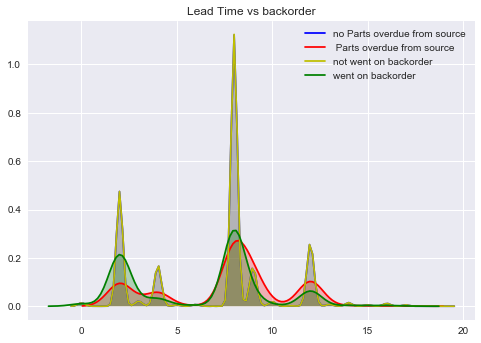

In [488]:


sns.kdeplot(orders[(orders['pieces_past_due'] == 0) & (orders['lead_time']<20)]['lead_time'],color='b', shade=True,label='no Parts overdue from source')
sns.kdeplot(orders[(orders['pieces_past_due'] == 1) & (orders['lead_time']<20)]['lead_time'], color='r',shade=True,label=' Parts overdue from source')
plt.title('lead_time vs  Parts overdue from source')

sns.kdeplot(orders[(orders['went_on_backorder'] == 0) & (orders['lead_time'] < 20)]['lead_time'],color='y', shade=True,label='not went on backorder')
sns.kdeplot(orders[(orders['went_on_backorder'] == 1) & (orders['lead_time'] < 20)]['lead_time'], color='g',shade=True,label='went on backorder')
plt.title('Lead Time vs backorder')

plt.show()

same thing with parts overdue, id there is no parts overdue from the source the products doesnt go backorder

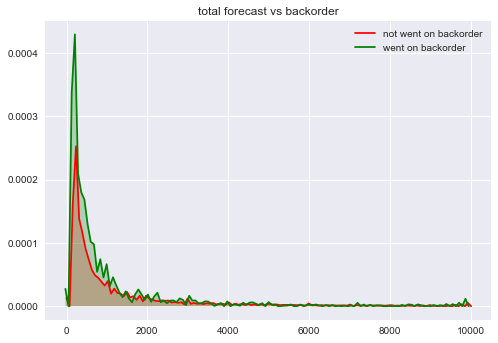

In [489]:
sns.kdeplot(orders[(orders['went_on_backorder'] == 0) & (orders['forecast_9_month']<10000)]['forecast_9_month'],color='r', shade=True,label='not went on backorder')
sns.kdeplot(orders[(orders['went_on_backorder'] == 1) & (orders['forecast_9_month']<10000)]['forecast_9_month'], color='g',shade=True,label='went on backorder')
plt.title('total forecast vs backorder')
plt.show()

Relationship between Sales and Forcast

## How predictable are sales?


I want to figure out what is the difference of sales and forecast when the product went on backorder.

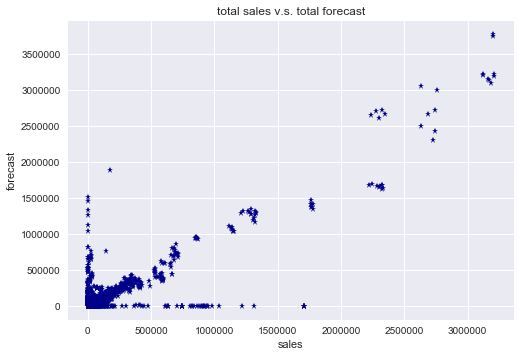

Total Forecast sales - Total Sales [[ 1.         0.8818941]
 [ 0.8818941  1.       ]]


In [490]:
plt.plot((orders.sales_9_month), orders.forecast_9_month,"*",color='darkblue')
plt.title('total sales v.s. total forecast')
plt.xlabel('sales')
plt.ylabel('forecast')
plt.show()
print('Total Forecast sales - Total Sales',np.corrcoef(orders.sales_9_month,orders.forecast_9_month))

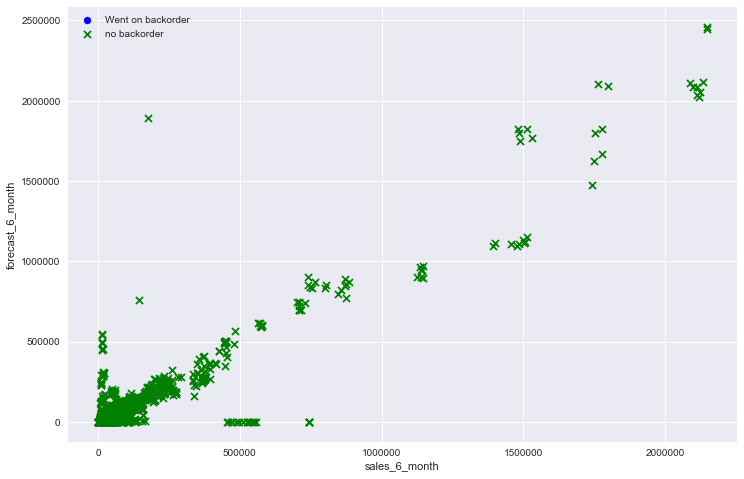

In [491]:
positive = sample_nomiss[sample_nomiss['went_on_backorder'].isin([1])]  
negative = sample_nomiss[sample_nomiss['went_on_backorder'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))  
ax.scatter(positive['sales_6_month'], positive['forecast_6_month'], s=50, c='b', marker='o', label='Went on backorder')  
ax.scatter(negative['sales_6_month'], negative['forecast_6_month'], s=50, c='g', marker='x', label='no backorder')  
ax.legend()  
ax.set_xlabel('sales_6_month')  
ax.set_ylabel('forecast_6_month') 
plt.show()

C:\Users\Hedi\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Hedi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


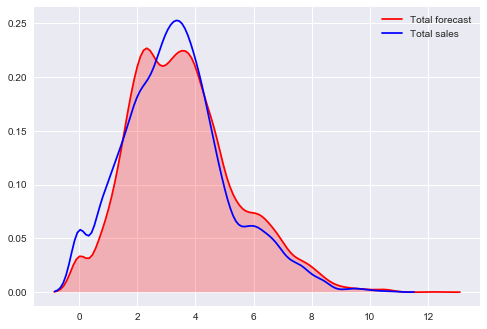

In [492]:
fc=orders[orders['went_on_backorder']==1]
#compare sales and forecast
sns.kdeplot(np.log(fc['forecast_9_month']),color='r', shade=True,label='Total forecast')
sns.kdeplot(np.log(fc['sales_9_month']),color='b', shade=False,label='Total sales')
plt.show()

In [493]:
o=orders[(orders.went_on_backorder==1)]
o=o[(o.went_on_backorder==1)]
#o.groupby(['sales_9_month', 'forecast_9_month']).size()

the probability of products with "parts overdue from source" that went on backorder is almost 98%.
If the product didn't have parts overdue, it is very unlikely it went on backorder.

In [494]:
p=orders[(orders.went_on_backorder==0) & (orders.pieces_past_due==0)]
prob=((len(p.sku)/len(orders.sku))*100)
print('Probability of product that had parts overdue and went on backorder',prob,'%')
pn=orders[(orders.went_on_backorder==1) & (orders.pieces_past_due==0)]
prob_pn=(len(pn.sku)/len(orders.sku))*100
print('Probability of product that had parts overdue and did not go on backorder',prob_pn,'%')


Probability of product that had parts overdue and went on backorder 97.894612112379 %
Probability of product that had parts overdue and did not go on backorder 0.6071001149384427 %


Probbility of source issue for part identified and went on backorder is 99% whichis very high.

In [495]:

p=orders[(orders.went_on_backorder==0) & (orders.potential_issue==0)]
#p=p['pieces_past_due'].value_counts().sort_index()
prob=(len(p.sku)/len(orders.sku))*100
print('Probability of product that had  Source issue for part identified and went on backorder',prob,'%')
print (p.size)
pn=orders[(orders.went_on_backorder==1) & (orders.potential_issue==0)]

prob_pn=(len(pn.sku)/len(orders.sku))*100
print('Probability of product that had  Source issue for part identified and did not go on backorder',prob_pn,'%')

Probability of product that had  Source issue for part identified and went on backorder 99.28021281385897 %
38541353
Probability of product that had  Source issue for part identified and did not go on backorder 0.6660505018188713 %


In [496]:
p=orders[(orders.went_on_backorder==0) & (orders.local_bo_qty==0)]
#p=p['pieces_past_due'].value_counts().sort_index()
prob=(len(p.sku)/len(orders.sku))*100
print('Probability of product that had  Source issue for part identified and went on backorder',prob,'%')
print (p.size)
pn=orders[(orders.went_on_backorder==1) & (orders.local_bo_qty==0)]

prob_pn=(len(pn.sku)/len(orders.sku))*100
print('Probability of product that had  Source issue for part identified and did not go on backorder',prob_pn,'%')


Probability of product that had  Source issue for part identified and went on backorder 98.03087933833375 %
38056352
Probability of product that had  Source issue for part identified and did not go on backorder 0.5861860580853863 %


In [497]:
p=orders[(orders.went_on_backorder==0) & (orders.pieces_past_due==0)& (orders.local_bo_qty==0)&(orders.potential_issue==0)]
prob=((len(p.sku)/len(orders.sku))*100)
print('Probability of product that had parts overdue and went on backorder',prob,'%')

pn=orders[(orders.went_on_backorder==1) & (orders.pieces_past_due==0)& (orders.local_bo_qty==0)&(orders.potential_issue==0)]
prob_pn=((len(pn.sku)/len(orders.sku))*100)
print('Probability of product that had parts overdue and went on backorder',prob_pn,'%')

Probability of product that had parts overdue and went on backorder 96.68941736873911 %
Probability of product that had parts overdue and went on backorder 0.5443579443792731 %


In [ ]:
p=orders[(orders.went_on_backorder==0) & (orders.pieces_past_due==0)& (orders.local_bo_qty==0)&(orders.potential_issue==0)]
prob=((len(p.sku)/len(orders.sku))*100)
print('Probability of product that had parts overdue and went on backorder',prob,'%')

pn=orders[(orders.went_on_backorder==1) & (orders.pieces_past_due==0)& (orders.local_bo_qty==0)&(orders.potential_issue==0)]
prob_pn=((len(pn.sku)/len(orders.sku))*100)
print('Probability of product that had parts overdue and went on backorder',prob_pn,'%')

In [498]:

p=orders[(orders.went_on_backorder==0) & (orders.ppap_risk==0)]
prob=((len(p.sku)/len(orders.sku))*100)
print('Probability of product that had parts overdue and went on backorder',prob,'%')


Probability of product that had parts overdue and went on backorder 87.35866718803692 %


##### Minimum recommend amount to stock
With more minimum recommended amount to stock the order volumes decrease.

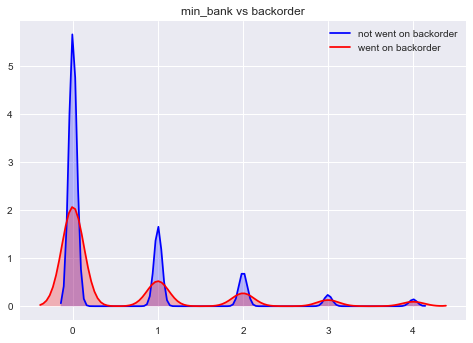

C:\Users\Hedi\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


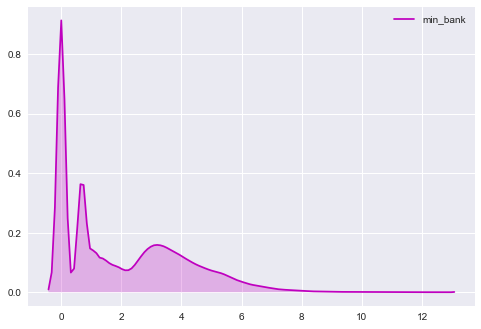

In [499]:
#binaries = ['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk',
               #'stop_auto_buy', 'rev_stop', 'went_on_backorder']
#check the  Minimum recommend amount to stock relationship with backorder
orders['min_bank']
sns.kdeplot(orders[(orders['went_on_backorder'] == 0) & (orders['min_bank'] < 5)]['min_bank'],color='b', shade=True,label='not went on backorder')
sns.kdeplot(orders[(orders['went_on_backorder'] == 1) & (orders['min_bank'] < 5)]['min_bank'], color='r',shade=True,label='went on backorder')
plt.title('min_bank vs backorder')
plt.show()

sales_sort=orders.sort_values('min_bank',ascending = False)
sns.kdeplot(np.log(sales_sort['min_bank']),color='m', shade=True)
plt.show()

In [500]:
min_order = orders['min_bank'].shape[0]
minOrder_backorders =sum(orders[pd.notnull(orders["min_bank"])]["went_on_backorder"])
minOrder_backorder_ratio = minOrder_backorders / (min_order)
print('Proportion of orders with minimum recommend amount to stock that went_on_backorder:',minOrder_backorder_ratio * 100)



Proportion of orders with minimum recommend amount to stock that went_on_backorder: 0.669072079438


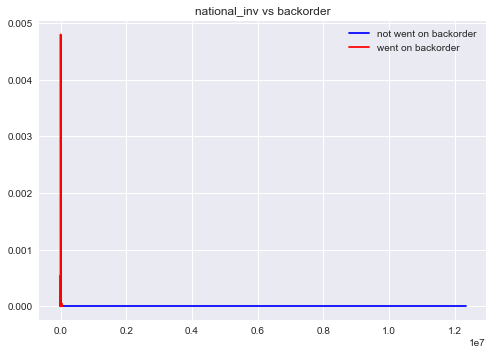

In [544]:
#national_inv         

orders['national_inv']
sns.kdeplot(orders[(orders['went_on_backorder'] == 0) & (orders['national_inv'])]['national_inv'],color='b', shade=True,label='not went on backorder')
sns.kdeplot(orders[(orders['went_on_backorder'] == 1) & (orders['national_inv'])]['national_inv'], color='r',shade=True,label='went on backorder')
plt.title('national_inv vs backorder')
plt.show()



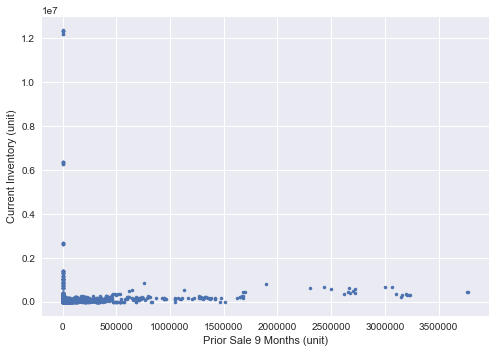

In [502]:
plt.plot(orders.forecast_9_month, orders.national_inv, marker='.', linestyle='None')
plt.xlabel('Prior Sale 9 Months (unit)')
plt.ylabel('Current Inventory (unit)')
plt.show()

C:\Users\Hedi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
C:\Users\Hedi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


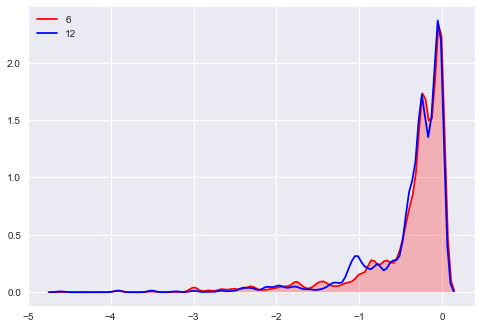

In [503]:
sns.kdeplot(np.log(fc['perf_6_month_avg']),color='r', shade=True,label='6')
sns.kdeplot(np.log(fc['perf_12_month_avg']),color='b', shade=False,label='12')
plt.show()

#### Normalization
Not too many bins yet, right?
A first insight we can explore is that quantities are in different greatness levels, according to the item.

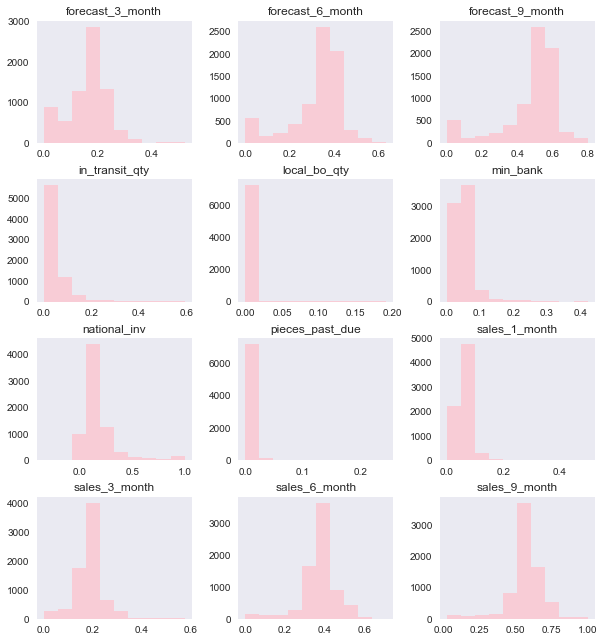

In [504]:
qty_related = ['national_inv', 'in_transit_qty', 'forecast_3_month', 
                   'forecast_6_month', 'forecast_9_month', 'min_bank',
                   'local_bo_qty', 'pieces_past_due', 'sales_1_month', 
                   'sales_3_month', 'sales_6_month', 'sales_9_month',]
sample_nomiss[qty_related] = normalize(sample_nomiss[qty_related], axis=1)
sample_nomiss[qty_related].hist(figsize=(10,11), alpha=0.7, color='pink', grid=False)
plt.show()


From above plot we can see the normal distribution 
Note that we used normalization (which forces standard deviation = 1), not scaling, which also forces mean equal to 0. This is because we want to keep some important informations about the part (for example, if inventory is lower than 0, we can correct that in preprocessing, or we will be misleading our models).

In [505]:
sample_nomiss.describe()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
count,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,...,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.0,7330.000000
mean,0.167979,6.251705,0.045414,0.161986,0.321475,0.477686,0.057881,0.186148,0.370035,0.569572,...,0.001772,0.836536,0.817207,0.000802,0.005184,0.003138,0.106548,0.955935,0.0,0.002183
std,0.172640,3.683638,0.055737,0.077671,0.119672,0.167573,0.031727,0.060596,0.088622,0.123055,...,0.008663,0.209326,0.208756,0.006573,0.071819,0.055932,0.308559,0.205255,0.0,0.046673
min,-0.347493,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020274,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,0.075707,2.000000,0.011003,0.127041,0.293561,0.453687,0.047314,0.166363,0.344685,0.530688,...,0.000000,0.750000,0.720000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000
50%,0.115020,8.000000,0.031447,0.176274,0.356613,0.530841,0.056233,0.185303,0.374191,0.574632,...,0.000000,0.920000,0.910000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000
75%,0.198882,8.000000,0.056707,0.207455,0.391123,0.574537,0.066257,0.206146,0.408343,0.623813,...,0.000000,0.980000,0.970000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000
max,0.999719,52.000000,0.591826,0.521368,0.633123,0.800556,0.499535,0.577176,0.706969,1.000000,...,0.243626,1.000000,1.000000,0.191739,1.000000,1.000000,1.000000,1.000000,0.0,1.000000


### Make the ML Model:
    

#### 1. First Model: Logistic Regression Model:  
Regression model:
why logistic model:

Split the data into a training and test (hold-out) set
Train on the training set, and test for accuracy on the testing set

In [1130]:
target=['went_on_backorder']
features=['national_inv','lead_time','in_transit_qty','forecast_3_month','forecast_6_month','forecast_9_month',
   'sales_1_month','sales_3_month','sales_6_month','sales_9_month','min_bank','potential_issue',
   'pieces_past_due','perf_6_month_avg','perf_12_month_avg','local_bo_qty','deck_risk',
   'oe_constraint','ppap_risk','stop_auto_buy']


In [1131]:
X = sample_nomiss[features]
#X = sample_nomiss[features].values
y = sample_nomiss['went_on_backorder'].values

In [1132]:
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best

In [1133]:
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.6):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("Accuracy on training data: {:0.2f}".format(training_accuracy))
    print("Accuracy on test data:     {:0.2f}".format(test_accuracy))
    return clf, Xtrain, ytrain, Xtest, ytest

In [1134]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           sample_nomiss, features, 'went_on_backorder',1)



C:\Users\Hedi\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


BEST PARAMS {'C': 10}
Accuracy on training data: 1.00
Accuracy on test data:     1.00


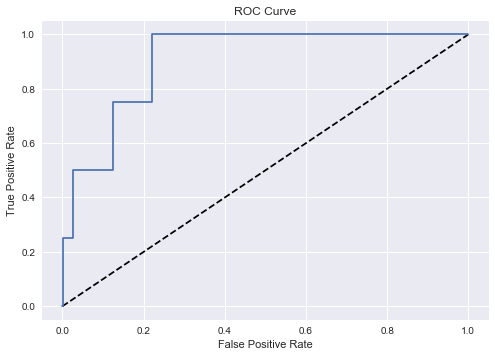

In [1135]:
#ROC curves provide a way to visually evaluate models
# Compute predicted probabilities: y_pred_prob
y_pred_prob = clf_l.predict_proba(Xtest_l)[:,1]
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(ytest_l, y_pred_prob)
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [1136]:
y_pred_prob = clf_l.predict_proba(Xtest_l)[:,1]
# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(ytest_l, y_pred_prob)))

# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(clf_l, X, y, cv=5, scoring='roc_auc')

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))



AUC: 0.9073599726775956
AUC scores computed using 5-fold cross-validation: [ 0.01708817  0.70927318  1.          0.33447254  1.        ]


In [1140]:
print(classification_report(ytest_l, (y_pred_prob).astype(int)))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      2928
          1       0.00      0.00      0.00         4

avg / total       1.00      1.00      1.00      2932



C:\Users\Hedi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [1137]:
print (len(Xtrain_l))
print(len(ytrain_l))
print(len(Xtest_l))
print(len(ytest_l))
print(len(X))
print(len(y))
print(np.mean(ytest_l))
print(np.sum(ytest_l==1))

4398
4398
2932
2932
7330
7330
0.00136425648022
4


Apply ML model to the test set

In [1097]:
backorder_test=pd.read_csv("Kaggle_Test_Dataset_v2.csv")
test = (backorder_test
              .replace(['Yes', 'No'], [1, 0]))               # make yes/no numeric

C:\Users\Hedi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [1098]:
test['lead_time'] = Imputer(strategy='median').fit_transform(
                                    test['lead_time'].values.reshape(-1, 1))
test = test.dropna()
for col in ['perf_6_month_avg', 'perf_12_month_avg']:
    test[col] = Imputer(missing_values=-99).fit_transform(
                                    test[col].values.reshape(-1, 1))

In [1099]:
test.isnull().sum().sum()

0

In [1100]:
len(test[test['lead_time']==1])/len(test['lead_time'])

1.23928534545079e-05

#### 2. Random Forest

In [1124]:
target=['went_on_backorder']
features=['national_inv','lead_time','in_transit_qty','forecast_3_month','forecast_6_month','forecast_9_month',
   'sales_1_month','sales_3_month','sales_6_month','sales_9_month','min_bank','potential_issue',
   'pieces_past_due','perf_6_month_avg','perf_12_month_avg','local_bo_qty','deck_risk',
   'oe_constraint','ppap_risk','stop_auto_buy']

In [1125]:
X = sample_nomiss[features]
#X = sample_nomiss[features].values
y = sample_nomiss['went_on_backorder'].values

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.4, random_state=42)

In [1126]:
forest = ensemble.RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=2)
forest.fit(Xtrain, ytrain)
# Print the score of the fitted random forest
print(forest.score(Xtrain, ytrain))

# Compute predictions on our test set features then print the length of the prediction vector
pred_forest =forest.predict(Xtest)
print(len(pred_forest))
print(classification_report(ytest, pred_forest))


0.9988631196
2932
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      2926
          1       0.00      0.00      0.00         6

avg / total       1.00      1.00      1.00      2932



C:\Users\Hedi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


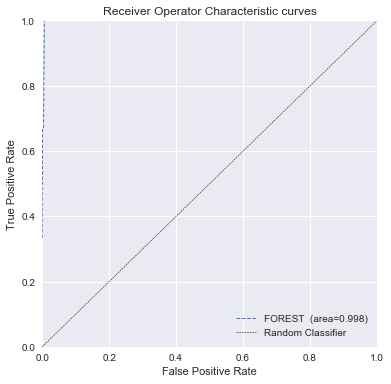

In [1127]:
def roc_auc_plot(ytrue, pred_forest, label=' ', l='-', lw=1.0):
    from sklearn.metrics import roc_curve, roc_auc_score
    fpr, tpr, _ = roc_curve(ytrue, pred_forest[:,1])
    ax.plot(fpr, tpr, linestyle=l, linewidth=lw,
            label="%s (area=%.3f)"%(label,roc_auc_score(ytrue, pred_forest[:,1])))

f, ax = plt.subplots(figsize=(6,6))

roc_auc_plot(ytest,forest.predict_proba(Xtest),label='FOREST ',l='--')


ax.plot([0,1], [0,1], color='k', linewidth=0.5, linestyle='--', 
        label='Random Classifier')    
ax.legend(loc="lower right")    
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_title('Receiver Operator Characteristic curves')
sns.despine()
plt.show()


In [1128]:
#Area under ROC:Large area under ROC curve the better our model is(AUC)
#Compute AUC
# If the AUC is greater than 0.5, the model is better than random guessing
# Compute predicted probabilities: y_pred_prob
y_pred_prob = forest.predict_proba(Xtest)[:,1]

# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(ytest, y_pred_prob)))

# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(forest, X, y, cv=5, scoring='roc_auc')

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

AUC: 0.998177261335156
AUC scores computed using 5-fold cross-validation: [ 0.99085783  0.83139667  1.          0.49077239  0.81703146]


In [1129]:
print(forest.feature_importances_)

[ 0.1168986   0.01063743  0.0566115   0.10499551  0.10743331  0.10077146
  0.03293654  0.09903207  0.03338843  0.03768537  0.00877658  0.
  0.00461509  0.01420646  0.05255315  0.19948112  0.00325528  0.
  0.01672211  0.        ]


The most important features(higher coficient) are national inventory,forecast_6_month and local quantity

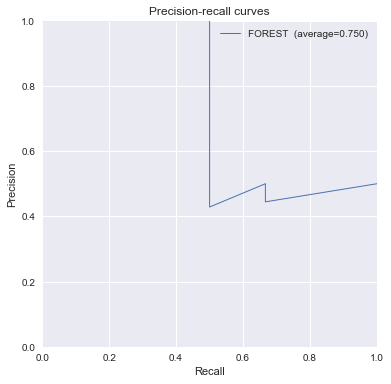

In [1058]:
def precision_recall_plot(y_true, y_proba, label=' ', l='-', lw=1.0):
    from sklearn.metrics import precision_recall_curve, average_precision_score
    precision, recall, _ = precision_recall_curve(y_test,
                                                  y_proba[:,1])
    average_precision = average_precision_score(y_test, y_proba[:,1],
                                                     average="micro")
    ax.plot(recall, precision, label='%s (average=%.3f)'%(label,average_precision),
            linestyle=l, linewidth=lw)

f, ax = plt.subplots(figsize=(6,6))

precision_recall_plot(ytest,forest.predict_proba(Xtest),label='FOREST ',l='-')


ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc="upper right")
ax.grid(True)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_title('Precision-recall curves')
sns.despine()
plt.show()